In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
if ('0.11' in sns.__version__) or ('0.12' in sns.__version__):
    sns.set_theme()
else:
    sns.set()
import sys
!{sys.executable} -m pip install textblob
import textblob

In [2]:
#https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset
tweets = pd.read_csv("Tweets.csv")
tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
#https://www.ncei.noaa.gov/cdo-web/datasets
climate = pd.read_csv("GHCND_sample_csv.csv")
print(climate.shape)

(31, 9)


In [4]:
#https://ia600501.us.archive.org/view_archive.php?archive=/32/items/twitter_cikm_2010/twitter_cikm_2010.zip&file=training_set_users.txt
training_users = pd.read_csv("training_set_users.txt", sep="\t", header=None, names=["UserID","UserLocation"])
training_users.head()


,UserID,UserLocation
0,14,San Francisco
1,15,San Francisco
2,18,"San Francisco, CA"
3,19922973,"Chicago, IL"
4,63963170,New York


In [5]:
#https://ia600501.us.archive.org/view_archive.php?archive=/32/items/twitter_cikm_2010/twitter_cikm_2010.zip&file=training_set_tweets.txt
training_tweets = pd.read_csv("training_set_tweets.txt", sep="\t", header=None, names=["UserID","TweetID","Tweet","CreatedAt"])
training_tweets = training_tweets[training_tweets["UserID"].str.isnumeric() == True]
training_tweets["UserID"] = training_tweets["UserID"].astype("int")

In [6]:
t_user_tweets = training_users.merge(training_tweets, on="UserID", how="left")
pol = pd.read_csv("uspollution_pollution_us_2000_2016.csv", usecols = ["City", "Date Local", "NO2 Mean", "SO2 Mean", "CO Mean"])
pol = pol[pol["Date Local"].str.contains("2016")]
t_user_tweets.head()
pol = pol.groupby("City")[["NO2 Mean", "SO2 Mean", "CO Mean"]].mean()
print(pol)

                            NO2 Mean  SO2 Mean   CO Mean
City                                                    
Arden-Arcade                9.122132  2.500177  0.431507
Baton Rouge                12.911402  1.113256  0.232938
Beltsville                 10.599064  0.413356  0.251720
Bethel Island               5.032235  1.471693  0.394839
Birmingham                  9.524873  0.835118  0.209514
Boston                     15.829273  0.676859  0.272121
Calexico                   15.283268  0.799027  0.512509
Capitan                     0.362757  0.240622  0.120765
Charlotte                   7.901285  0.174032  0.243189
Cincinnati                  9.448397  0.992820  0.260071
Cleveland                   9.913122  2.025474  0.287719
Concord                     6.750253  0.625520  0.308608
Dallas                     11.834022  0.194095  0.264207
Davenport                   6.215778  0.257715  0.209559
Deer Park                   7.371138  0.271792  0.179672
Dentsville (Dents)          9.3

In [7]:

t_user_tweets["Sentiment"] = t_user_tweets["Tweet"].astype(str).apply(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
city = r'^([^,]*)'
state = r',\s*([^,]*)'
t_user_tweets["City"] = t_user_tweets["UserLocation"].str.extract(city)
t_user_tweets["State"] = t_user_tweets["UserLocation"].str.extract(state)
print(t_user_tweets.shape)
t_user_tweets.dropna(subset=['Tweet'], inplace=True)
tweets = pd.merge(t_user_tweets, pol, on = "City", how = "left")
tweets.head()

(116890, 8)


,UserID,UserLocation,TweetID,Tweet,CreatedAt,Sentiment,City,State,NO2 Mean,SO2 Mean,CO Mean
0,14,San Francisco,1567978127,The flock of bees splatter the windshield like...,2009-04-20 14:09:20,0.000000,San Francisco,NaN,NaN,NaN,NaN
1,14,San Francisco,1551907112,"Watching him on TV, I wondered how I became so...",2009-04-18 12:16:56,0.000000,San Francisco,NaN,NaN,NaN,NaN
2,14,San Francisco,1539281043,My inner dirthead child limps a smile at the ...,2009-04-16 22:30:57,0.008333,San Francisco,NaN,NaN,NaN,NaN
3,14,San Francisco,1513711531,Riding this blue steel dog Down thru the atmos...,2009-04-13 21:14:58,0.073611,San Francisco,NaN,NaN,NaN,NaN
4,14,San Francisco,1455281562,"Driving this blue steel dog, pregnant and lumb...",2009-04-04 22:48:26,0.166667,San Francisco,NaN,NaN,NaN,NaN


In [8]:
plot = tweets.groupby("City")[["Sentiment", "NO2 Mean"]].mean().sort_values("NO2 Mean")

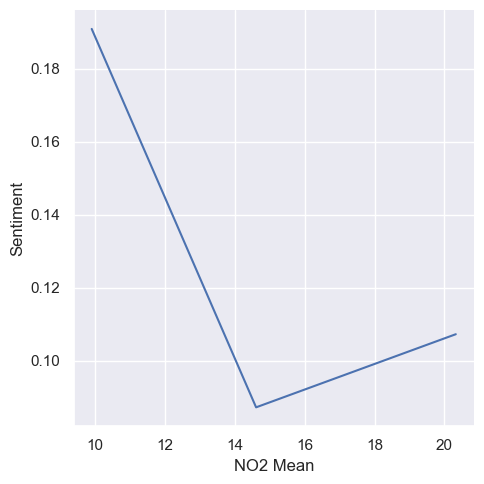

In [9]:
sns.relplot(x = "NO2 Mean", y = "Sentiment", data = plot, kind = "line")